# Analysis of Foursquare Data

# NYU - CUSP UDP Capstone
# Foursquare + Urban Complexity Index  + NYC Merge by CT 
## Brief
This notebook 
1. Part I. Data Processing

    - import Foursquare data
    - imports the Census Tract shapefile
    - import Typologies
    - merges topologies
    - Spatail join by Census Tract
    - merges topologies
    - map topologies
    - map Businesses
    - create urban complexity index
1. Part II. Modeling
    - Performs a classifcation task on Typologies
###  You can refer to https://github.com/mv1742/updny_2

In [105]:
import os
import requests
import shapely
import json

# !pip install pydotplus
from sklearn import tree
# from IPython.display import Image  
# import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon', 'seed', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part I. Data Processing
## Foursquare Data
- import Foursquare data

In [2]:
data = gpd.read_file('NYU_March2018_subset30.geojson')

In [3]:
(list(data.columns)), data.shape

(['id',
  'Place Name',
  'Rating',
  'Checkins',
  'Users',
  'Visits',
  'Pricing',
  'Type',
  'Category',
  'Class',
  'geometry'],
 (106287, 11))

In [4]:
data.head(1)

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,geometry
0,50ad0afce4b0b4a7430e2268,Terry's Wine Shop,8.8,294,217,337,NaN,Wine Shop,Consumption,Optional,POINT (-74.00034036700906 40.73518392010902)


In [5]:
list(data.columns)[-4:-1]

['Type', 'Category', 'Class']

In [6]:
X_dummies = data[list(data.columns)[-4:-1]]
print(X_dummies.shape)
X_dummies = pd.get_dummies(X_dummies)
Fq_dummies = pd.concat([data, X_dummies], axis=1, join='inner')  
Fq_dummies.shape

(106287, 3)


(106287, 716)

# Census Tract shapefile
- imports the Census Tract shapefile


In [7]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /Users/mkm/Capstone/udpny_2


In [8]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)


Master: /Users/mkm/Capstone/udpny_2


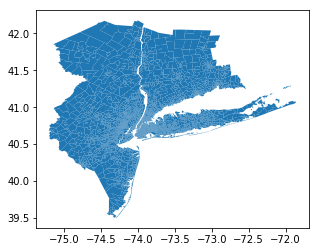

In [9]:
# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
NYCzip=gpd.read_file('../Censustracts/region.shp')
NYCzip.plot()


In [10]:
NYCzip.columns

Index(['aland_mi', 'objectid', 'statefp', 'countyfp', 'tractce', 'geoid',
       'name', 'namelsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat',
       'intptlon', 'shape_leng', 'shape_area', 'atotal', 'atotal_mi',
       'cartodb_id', 'geoid_1', 'hou16', 'hou16moe', 'hou16cv', 'houv16',
       'houv16moe', 'houv16cv', 'houo16', 'houo16moe', 'houo16cv', 'hour16',
       'hour16moe', 'hour16cv', 'emtot15', 'empr15', 'emoff15', 'emins15',
       'emind15', 'emser15', 'emoth15', 'geometry'],
      dtype='object')

In [11]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

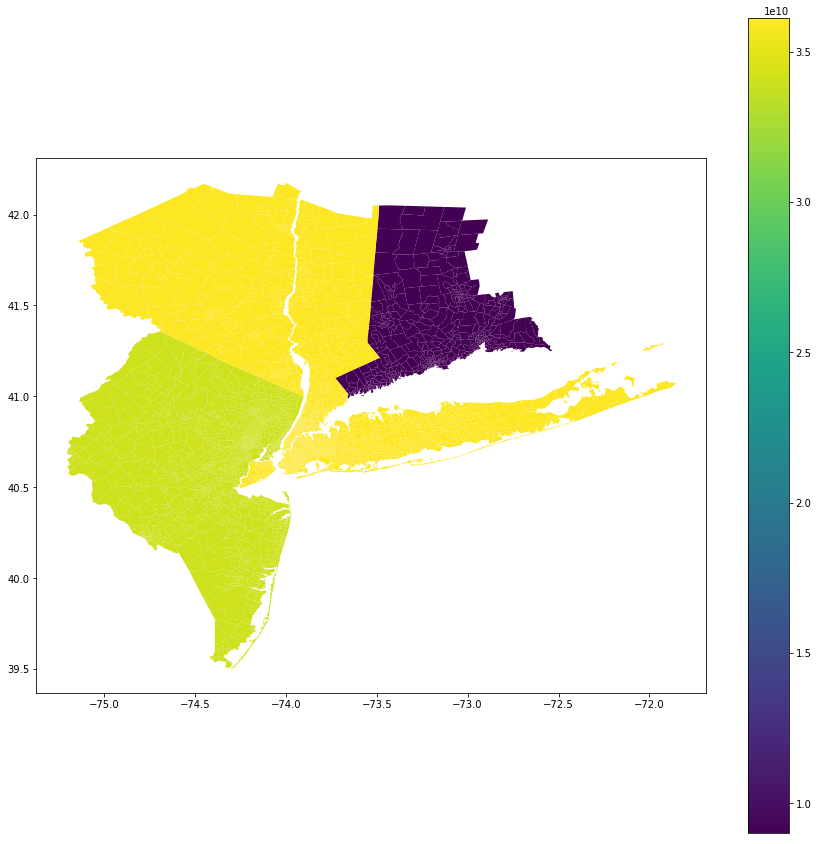

In [12]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

# Typologies
- import Typologies
- merges topologies
- map topologies

In [13]:
Typologiespd=pd.read_csv('../NY_final_data_for_typologies_1.19.19.csv')
Typologiesgdp = gpd.GeoDataFrame(Typologiespd)
len(Typologiesgdp.columns)

82

In [14]:
Typologiesgdp['Type_1.19'].replace('MHI - Advanced Exclusion','MHI - Ongoing Exclusion',inplace=True)


In [15]:
Typologiesgdp['Type_1.19'].unique()

array(['VHI - Super Gentrification or Exclusion',
       'MHI - Ongoing Exclusion',
       'MHI - Stable or Early Stage of Exclusion',
       'LI - At Risk of Gentrification', 'MHI - Advanced Gentrification',
       'LI - Not Losing Low-Income Households',
       'LI - Ongoing Displacement of Low-Income Households',
       'Missing Data', 'LI - Ongoing Gentrification', nan], dtype=object)

In [16]:
Typologiesgdp['Type_1.19'].describe()

count                                         5294
unique                                           9
top       MHI - Stable or Early Stage of Exclusion
freq                                          2004
Name: Type_1.19, dtype: object

MHI - Stable or Early Stage of Exclusion              0.378542
MHI - Ongoing Exclusion                               0.143937
LI - At Risk of Gentrification                        0.098602
LI - Not Losing Low-Income Households                 0.091046
LI - Ongoing Displacement of Low-Income Households    0.087457
MHI - Advanced Gentrification                         0.069890
VHI - Super Gentrification or Exclusion               0.059312
LI - Ongoing Gentrification                           0.051946
Missing Data                                          0.019267
Name: Type_1.19, dtype: float64

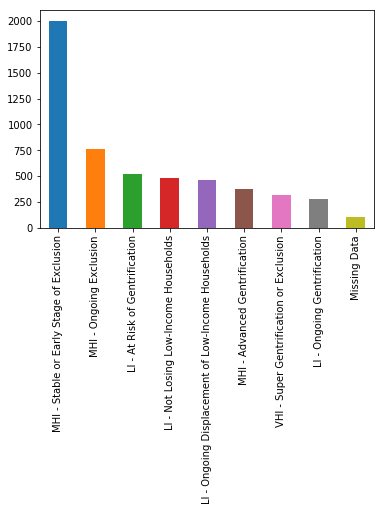

In [17]:
Typologiesgdp['Type_1.19'].value_counts().plot(kind='bar')
Typologiesgdp['Type_1.19'].value_counts()/Typologiesgdp['Type_1.19'].value_counts().sum()

In [18]:
Typologiesgdp['Type_1.19'].value_counts().sum()

5294

In [19]:
# Typologiesgdp['Type_binary'] = Typologiesgdp['Type_1.19']
# Typologiesgdp['Type_binary'].replace('VHI - Super Gentrification or Exclusion',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - At Risk of Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('Missing Data',0,inplace=True)
# Typologiesgdp['Type_binary'].replace(nan,0,inplace=True)


In [20]:
# Typologiesgdp['Type_binary'].unique()

In [21]:
# Typologiesgdp.to_csv('typologies_binary.csv')
# Typologiesgdp.drop(columns='Type_binary', inplace=True)

In [22]:
Typologiesgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiesgdp.tail()
cols_typ = ['GEOID','Type_1.19']
print(type(Typologiesgdp.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
Typologiesgdp = Typologiesgdp.loc[:,cols_typ]
Typologiesgdp.head()

<class 'numpy.float64'>


,GEOID,Type_1.19
0,9.001010e+09,VHI - Super Gentrification or Exclusion
1,9.001010e+09,VHI - Super Gentrification or Exclusion
2,9.001010e+09,VHI - Super Gentrification or Exclusion
3,9.001010e+09,VHI - Super Gentrification or Exclusion
4,9.001010e+09,VHI - Super Gentrification or Exclusion


In [23]:
merged = NYCzip.merge(Typologiesgdp,on='GEOID')
merged.tail()

,GEOID,geometry,Type_1.19
5285,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,Missing Data
5286,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,LI - Ongoing Gentrification
5287,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",LI - Ongoing Displacement of Low-Income Househ...
5288,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,LI - Ongoing Gentrification
5289,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",MHI - Stable or Early Stage of Exclusion


In [24]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

<class 'geopandas.geodataframe.GeoDataFrame'> (5290, 3)


(5290, 3)

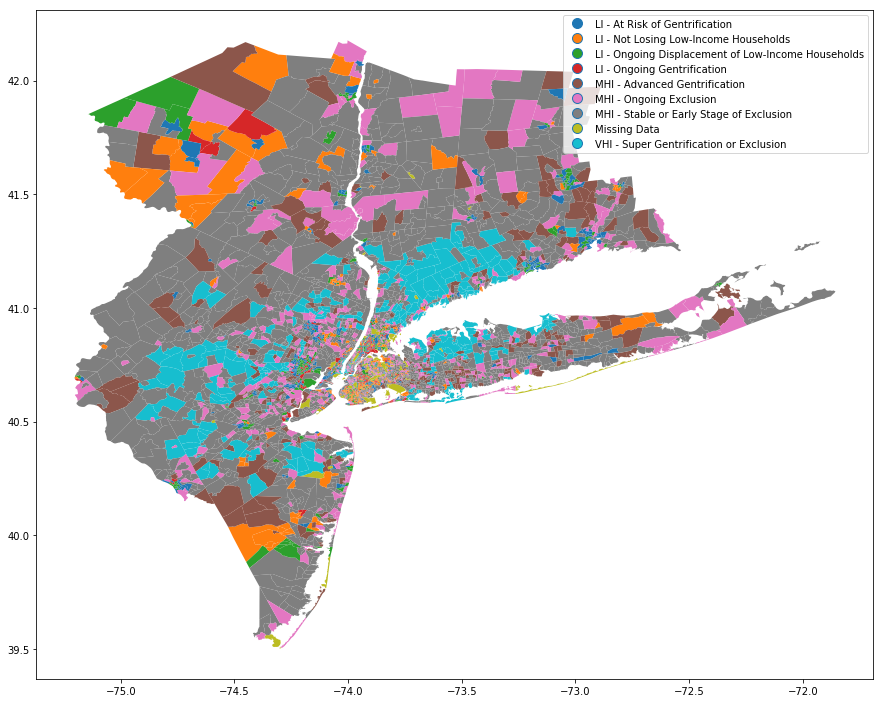

In [25]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='Type_1.19',legend = True, ax=ax)

# Spatail Join
- Spatail join by Census Tract
- map Businesses


In [26]:
mergedgpd.crs, data.crs, mergedgpd.shape, data.shape

(None, {'init': 'epsg:4326'}, (5290, 3), (106287, 11))

In [27]:
mergedgpd.crs = {'init' :'epsg:4326'}

In [28]:
mergedgpd.crs

{'init': 'epsg:4326'}

In [58]:
data_sjoined_sum = data_sjoined.groupby(by='GEOID').sum()
print(data_sjoined_sum.shape,data_sjoined_sum.columns)
data_sjoined_sum = data_sjoined_sum.reset_index()
data_sjoined_sum_merged = data_sjoined_sum.merge(mergedgpd, on='GEOID', how='inner')
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)
data_sjoined_sum_merged = gpd.GeoDataFrame(data_sjoined_sum_merged)
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)

(3009, 711) Index(['index_right', 'Rating', 'Checkins', 'Users', 'Visits', 'Pricing',
       'Type_ATM', 'Type_Accessories Store', 'Type_Acupuncturist',
       'Type_Adult Boutique',
       ...
       'Category_Leisure', 'Category_Mobility', 'Category_Nutrition',
       'Category_Personal care', 'Category_Social', 'Category_Taking care',
       'Category_Unknown', 'Class_', 'Class_Necessary', 'Class_Optional'],
      dtype='object', length=711)
(3009, 714) Index(['GEOID', 'index_right', 'Rating', 'Checkins', 'Users', 'Visits',
       'Pricing', 'Type_ATM', 'Type_Accessories Store', 'Type_Acupuncturist',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'geometry', 'Type_1.19'],
      dtype='object', length=714)
(3009, 714) Index(['GEOID', 'index_right', 'Rating', 'Checkins', 'Users', 'Visits',
       'Pricing', 'Type_ATM', 'Type_Accessories Store',

In [59]:
Fq_dummies.shape,data_sjoined_sum.shape, len(data_sjoined_sum_merged.GEOID.unique())

((106287, 716), (3009, 712), 3009)

In [60]:
data_sjoined_sum_merged.rename(columns={"Type_1.19": "Typologies"}, inplace = True)

No handles with labels found to put in legend.


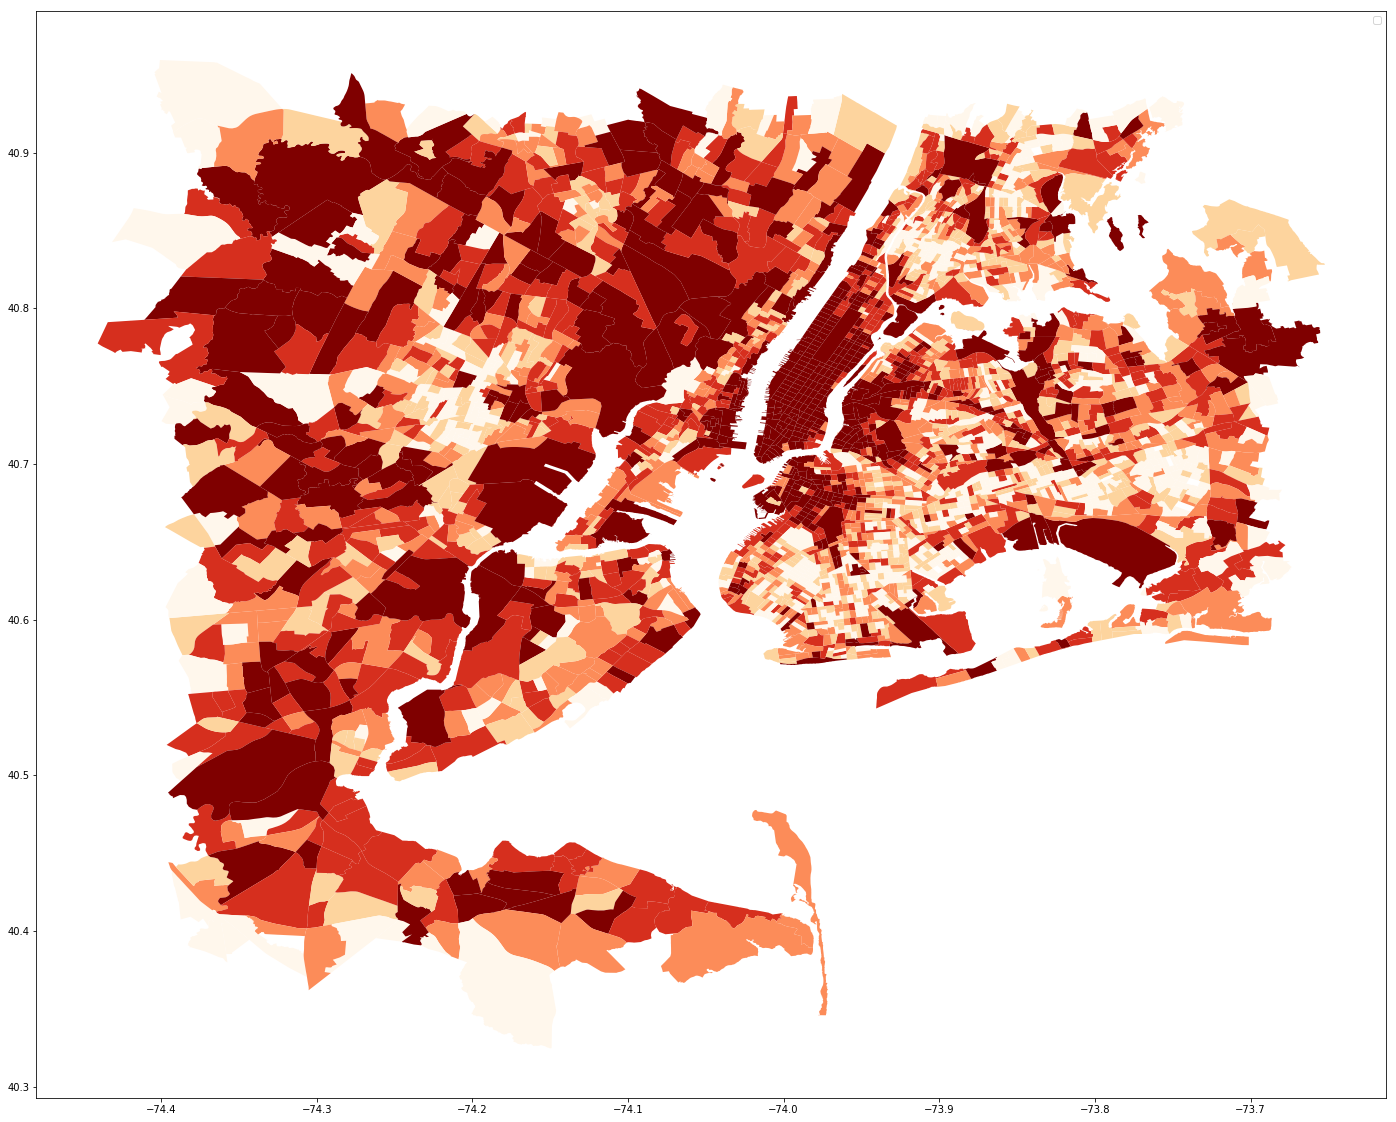

In [72]:
plt.rcParams['figure.figsize'] = (30, 20)
ax = data_sjoined_sum_merged.plot(column='Checkins', scheme='quantiles', cmap='OrRd')
ax.legend()

In [62]:
data_sjoined_sum_merged.drop(columns= 'index_right',inplace=True)
data_sjoined_sum_merged.iloc[:,:6]
data_sjoined_sum_merged.columns

Index(['GEOID', 'Rating', 'Checkins', 'Users', 'Visits', 'Pricing', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'geometry', 'Typologies'],
      dtype='object', length=713)

In [63]:
# sfig = pd.scatter_matrix(data_sjoined_sum_merged.iloc[:,:6], s=30, figsize=(10, 10), diagonal='kde')

## Shannon Index
- create urban complexity index based on urban activities
- on census tract levle

In [64]:
import skbio

In [65]:
print (
data_sjoined_sum_merged.shape,
data_sjoined_sum_merged.columns)

(3009, 713) Index(['GEOID', 'Rating', 'Checkins', 'Users', 'Visits', 'Pricing', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'geometry', 'Typologies'],
      dtype='object', length=713)


In [66]:
data_sjoined_sum_merged.iloc[:,-16:-5] 

,Category_Civic,Category_Consumption,Category_Education,Category_Income,Category_Leisure,Category_Mobility,Category_Nutrition,Category_Personal care,Category_Social,Category_Taking care,Category_Unknown
0,3.0,7.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,3.0
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
2,1.0,7.0,2.0,0.0,2.0,5.0,3.0,3.0,3.0,0.0,1.0
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
4,4.0,5.0,1.0,1.0,4.0,2.0,4.0,4.0,8.0,0.0,3.0
5,3.0,8.0,0.0,2.0,4.0,2.0,4.0,4.0,6.0,1.0,7.0
6,6.0,27.0,3.0,37.0,15.0,3.0,18.0,8.0,16.0,3.0,23.0
7,2.0,7.0,0.0,4.0,4.0,0.0,2.0,7.0,12.0,4.0,4.0
8,3.0,2.0,1.0,1.0,2.0,2.0,6.0,5.0,11.0,4.0,4.0
9,1.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,4.0,0.0,4.0


In [67]:
shannon_index = []
for i in range(0, len(data_sjoined_sum_merged)):
    s = skbio.diversity.alpha.shannon(data_sjoined_sum_merged.iloc[i,-16:-5].astype('int'),base=2)
    shannon_index.append(s)

/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/skbio/diversity/alpha/_base.py:869: RuntimeWarning: invalid value encountered in true_divide
  freqs = counts / counts.sum()


In [68]:
skbio.diversity.alpha.shannon(data_sjoined_sum_merged.iloc[0,-16:-5].astype('int'),base=2)

2.713124384036735

In [69]:
data_sjoined_sum_merged['Diversity']  = shannon_index

In [73]:
data_sjoined_sum_merged.shape

(3009, 714)

In [74]:
data_sjoined_sum_merged.head()

,GEOID,Rating,Checkins,Users,Visits,Pricing,Type_ATM,Type_Accessories Store,Type_Acupuncturist,Type_Adult Boutique,...,Category_Personal care,Category_Social,Category_Taking care,Category_Unknown,Class_,Class_Necessary,Class_Optional,geometry,Typologies,Diversity
0,34003003200,20.0,6591,2767,10611,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,3.0,4.0,12.0,POLYGON ((-73.99327399959544 40.92387300033873...,MHI - Stable or Early Stage of Exclusion,2.713124
1,34003003401,0.0,404,47,412,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,3.0,POLYGON ((-74.01265600037409 40.91041700034431...,MHI - Advanced Gentrification,0.970951
2,34003003402,13.6,4444,1722,6407,5.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,1.0,1.0,10.0,16.0,"POLYGON ((-73.9994910003094 40.92003999984609,...",MHI - Ongoing Exclusion,2.920599
3,34003003500,13.4,3279,1427,4469,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,3.0,0.0,5.0,POLYGON ((-73.98440499979093 40.91205200019972...,LI - Not Losing Low-Income Households,1.905639
4,34003004001,11.6,2135,1434,4319,14.0,0.0,0.0,0.0,0.0,...,4.0,8.0,0.0,3.0,3.0,8.0,25.0,POLYGON ((-74.02548100004816 40.88172900029316...,MHI - Stable or Early Stage of Exclusion,3.104244


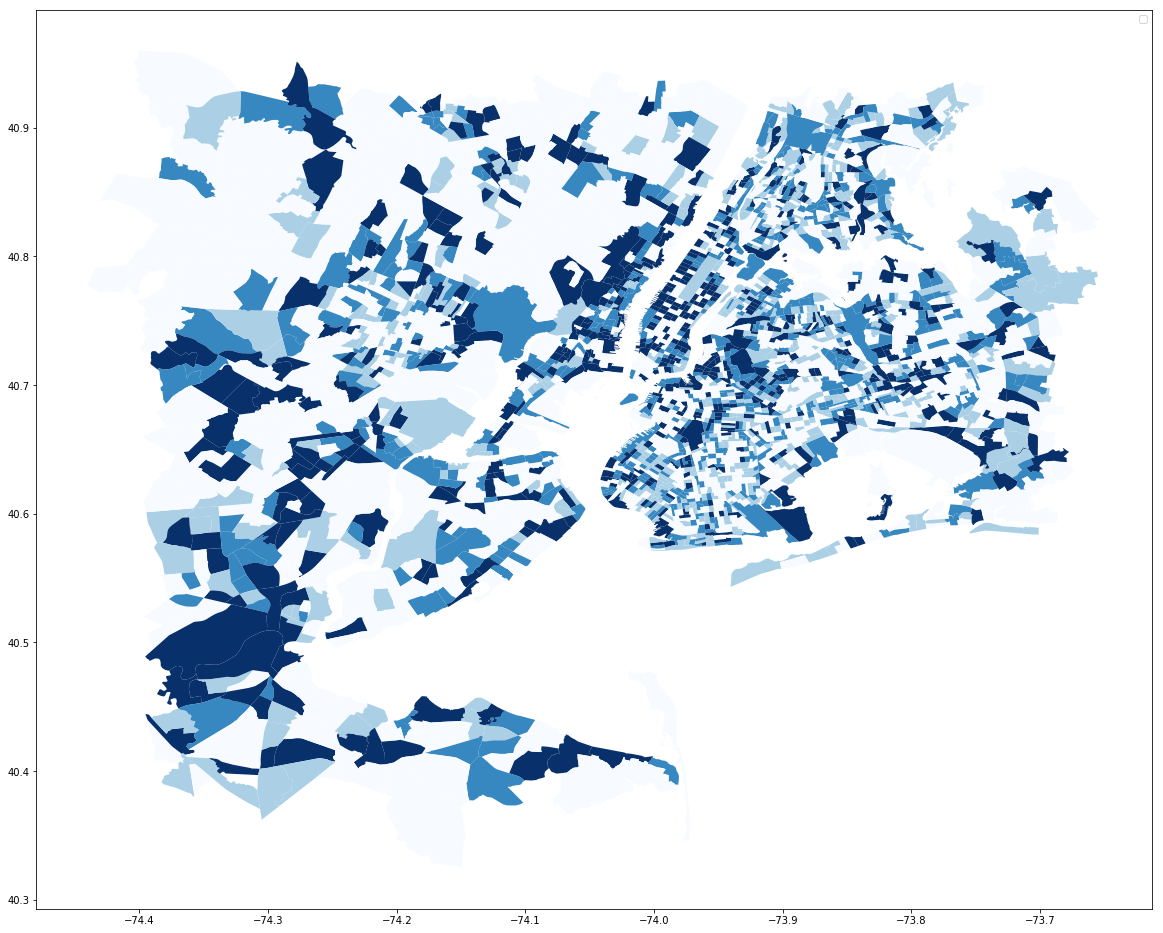

In [75]:
plt.rcParams['figure.figsize'] = (20, 20)
ax = data_sjoined_sum_merged.plot(column='Diversity', scheme='quantiles', cmap='Blues')
ax.legend('Diversity')

In [76]:
data_sjoined_sum_merged.sort_values(by='Diversity',ascending= False).head(5)

,GEOID,Rating,Checkins,Users,Visits,Pricing,Type_ATM,Type_Accessories Store,Type_Acupuncturist,Type_Adult Boutique,...,Category_Personal care,Category_Social,Category_Taking care,Category_Unknown,Class_,Class_Necessary,Class_Optional,geometry,Typologies,Diversity
98,34003054400,18.8,10581,4258,15052,19.0,0.0,0.0,0.0,0.0,...,7.0,6.0,6.0,10.0,10.0,26.0,41.0,"POLYGON ((-74.0142829998606 40.89412700006104,...",MHI - Stable or Early Stage of Exclusion,3.356112
813,36005007600,0.0,1692,645,2073,8.0,0.0,0.0,0.0,0.0,...,3.0,3.0,1.0,2.0,2.0,10.0,15.0,POLYGON ((-73.86680599959719 40.83483699982771...,LI - Ongoing Displacement of Low-Income Househ...,3.355834
708,34039033200,72.0,16292,11847,30519,12.0,0.0,0.0,0.0,0.0,...,3.0,5.0,5.0,4.0,4.0,18.0,22.0,POLYGON ((-74.23766400029341 40.68979999967026...,MHI - Advanced Gentrification,3.353859
448,34017016800,32.9,5589,4034,9201,10.0,0.0,0.0,0.0,0.0,...,4.0,5.0,3.0,2.0,2.0,12.0,21.0,POLYGON ((-74.02847999985212 40.77120099972641...,LI - Ongoing Displacement of Low-Income Househ...,3.337024
208,34013012200,27.3,5981,3031,10223,5.0,0.0,0.0,0.0,0.0,...,2.0,3.0,2.0,4.0,4.0,10.0,12.0,POLYGON ((-74.24365899976306 40.73033900034467...,LI - At Risk of Gentrification,3.334679


# Part II. Modeling
### Analysis ## FOURSQUARE + Diversity index

In [77]:
# Features = ['All','Visits_Only','No_Visits','Class','Top11_Types']
# X_foursquare ={}
# for feature in Features:
#     X_foursquare[feature] = data_sjoined_sum_merged.drop(['Typologies','GEOID','geometry'],axis =1).copy()

# # All
# # Visits_Only
# X_foursquare['Visits_Only'] = X_foursquare['Visits_Only'].iloc[:,:4]

# # No_Visits
# X_foursquare['No_Visits'] = data_sjoined_sum_merged.drop(['Visits','Rating','Users','Checkins','Typologies','GEOID','geometry'],axis =1).copy()

# # Class
# X_foursquare['Class'] = X_foursquare['Class'].iloc[:,-14:]

# # Topp1_Types
# type_cols = ['Type_Pizza Place','Type_Italian Restaurant','Type_Coffee Shop','Type_Bar','Type_Donut Shop',
#              'Type_Sandwich Place','Type_Fast Food Restaurant','Type_Chinese Restaurant','Type_American Restaurant',
#              'Type_Mexican Restaurant','Type_Deli / Bodega','Type_Café']
# X_foursquare['Top11_Types'] = X_foursquare['Top11_Types'][type_cols]

# y = data_sjoined_sum_merged.Typologies

# for feature in Features:

#     print(X_foursquare[feature].shape)
#     X_foursquare[feature].dropna(inplace=True)
#     print(X_foursquare[feature].shape)

In [78]:
### Preprocessing Data
### Preprocessing Data
data_sjoined_sum_merged.dropna(inplace=True)
X_foursquare = data_sjoined_sum_merged.drop(['Typologies','GEOID','geometry'],axis =1).copy()
# X_foursquare = data_sjoined_sum_merged.drop(['Typologies', 'geometry'],axis =1).copy()
y = data_sjoined_sum_merged.Typologies

## change to zeros

# replace with mean/median

# create a new

print(X_foursquare.shape)
# X_foursquare.replace(False,0,inplace=True)
# X_foursquare.replace('FALSE',0,inplace=True)
# X_foursquare.replace('#NULL!',0,inplace=True)
# X_foursquare.replace(nan,0,inplace=True)

X_foursquare.dropna(inplace=True)
print(X_foursquare.shape)


(3008, 711)
(3008, 711)


In [79]:
for string in data_sjoined_sum_merged.columns:
    print(string)
#     data_sjoined_sum_merged.rename({string:str(string.encode('utf-8'))},axis='columns',inplace=True)
list(data_sjoined_sum_merged.columns)

GEOID
Rating
Checkins
Users
Visits
Pricing
Type_ATM
Type_Accessories Store
Type_Acupuncturist
Type_Adult Boutique
Type_Adult Education Center
Type_Advertising Agency
Type_Afghan Restaurant
Type_African Restaurant
Type_Airport
Type_Airport Food Court
Type_Airport Gate
Type_Airport Lounge
Type_Airport Service
Type_Airport Terminal
Type_Airport Tram
Type_Alternative Healer
Type_American Restaurant
Type_Amphitheater
Type_Animal Shelter
Type_Antique Shop
Type_Apres Ski Bar
Type_Aquarium
Type_Arcade
Type_Arepa Restaurant
Type_Argentinian Restaurant
Type_Art Gallery
Type_Art Museum
Type_Art Studio
Type_Arts & Crafts Store
Type_Arts & Entertainment
Type_Asian Restaurant
Type_Assisted Living
Type_Astrologer
Type_Athletics & Sports
Type_Auditorium
Type_Australian Restaurant
Type_Austrian Restaurant
Type_Auto Dealership
Type_Auto Garage
Type_Auto Workshop
Type_Automotive Shop
Type_BBQ Joint
Type_Baby Store
Type_Badminton Court
Type_Bagel Shop
Type_Baggage Claim
Type_Bakery
Type_Ballroom
Type_Bank

['GEOID',
 'Rating',
 'Checkins',
 'Users',
 'Visits',
 'Pricing',
 'Type_ATM',
 'Type_Accessories Store',
 'Type_Acupuncturist',
 'Type_Adult Boutique',
 'Type_Adult Education Center',
 'Type_Advertising Agency',
 'Type_Afghan Restaurant',
 'Type_African Restaurant',
 'Type_Airport',
 'Type_Airport Food Court',
 'Type_Airport Gate',
 'Type_Airport Lounge',
 'Type_Airport Service',
 'Type_Airport Terminal',
 'Type_Airport Tram',
 'Type_Alternative Healer',
 'Type_American Restaurant',
 'Type_Amphitheater',
 'Type_Animal Shelter',
 'Type_Antique Shop',
 'Type_Apres Ski Bar',
 'Type_Aquarium',
 'Type_Arcade',
 'Type_Arepa Restaurant',
 'Type_Argentinian Restaurant',
 'Type_Art Gallery',
 'Type_Art Museum',
 'Type_Art Studio',
 'Type_Arts & Crafts Store',
 'Type_Arts & Entertainment',
 'Type_Asian Restaurant',
 'Type_Assisted Living',
 'Type_Astrologer',
 'Type_Athletics & Sports',
 'Type_Auditorium',
 'Type_Australian Restaurant',
 'Type_Austrian Restaurant',
 'Type_Auto Dealership',
 'T

In [80]:
data_sjoined_sum_merged.columns

Index(['GEOID', 'Rating', 'Checkins', 'Users', 'Visits', 'Pricing', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       ...
       'Category_Personal care', 'Category_Social', 'Category_Taking care',
       'Category_Unknown', 'Class_', 'Class_Necessary', 'Class_Optional',
       'geometry', 'Typologies', 'Diversity'],
      dtype='object', length=714)

In [81]:
# data_sjoined_sum_merged.to_csv('data_sjoined_sum_merged.csv')
# data_sjoined_sum_merged.columns

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_foursquare, y, test_size = 0.3, random_state = 1)    

In [83]:
R2 = {}
model = {}
modelslist = ['Logit','DT','RF','SVM'] 

# LR

In [84]:
## Logistic Reeg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
import matplotlib.pylab
%pylab inline
logit_1 = LogisticRegression(C = 10000)
print(X_train.shape,y_train.shape)
logit_1.fit(X_train, y_train)
print(logit_1.score(X_test,y_test))
model['Logit'] = logit_1.score(X_test,y_test)

Populating the interactive namespace from numpy and matplotlib
(2105, 711) (2105,)


/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figure']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.292358803986711


/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# DT

In [85]:
# Decision Tree
# Decision Tree

In [86]:
# Print tree
# # If you want to install GraphViz on your own machine:

## conda install python-graphviz
# # pip install pydot
# # pip install pydotplus


# Xc_pdcolumns = X_train.columns
# Xc_pdcolumns_new  = []
# for string in Xc_pdcolumns:
#     print(string)
#     string = str(string.encode('utf-8'))  # or:
#     Xc_pdcolumns_new.append(string)
# print(Xc_pdcolumns_new)

In [87]:
# thestring=tree.export_graphviz(dt)
# thestring=tree.export_graphviz(dt,out_file=None,
#                          feature_names=Xc_pdcolumns_new,  
#                          class_names=Xc_pdcolumns_new,  
#                           class_names=dt.classes_,  
#                                filled=True, rounded=True,  
#                          special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
# graph = pydotplus.graph_from_dot_data(thestring)  
# Image(graph.create_png())

In [88]:
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
param_grid = {'max_depth':range(1,11),'max_leaf_nodes':range(2,11)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid,scoring='accuracy')
ds=gr.fit(X_train,y_train)
print (ds.best_params_)

print(gr.score(X_test,y_test))


/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1, 'max_leaf_nodes': 2}
0.2956810631229236


In [89]:
seed = 5
print(y_train.shape, X_train.shape)

OS = []
for c in range(5):

    dt=DecisionTreeClassifier()


    dt = DecisionTreeClassifier(max_depth=ds.best_params_['max_depth'],max_leaf_nodes=ds.best_params_['max_leaf_nodes'])
    dt.fit(X_train, y_train)
    pred=dt.predict_proba(X_test)[:,1]
    OS.append(dt.score(X_test,y_test))
    
print(gr.score(X_test,y_test))
model['DT'] = mean(OS)
model

(2105,) (2105, 711)
0.2956810631229236


{'Logit': 0.292358803986711, 'DT': 0.2956810631229236}

In [90]:
# print (rs.best_params_['max_depth'])

In [91]:
OS=[]
for i in range(2,500,25):
    dt=DecisionTreeClassifier(max_leaf_nodes=i)
    dt.fit(X_train,y_train)
    OS.append(dt.score(X_test,y_test))
np.mean(OS), np.max(OS)

(0.22740863787375415, 0.2956810631229236)

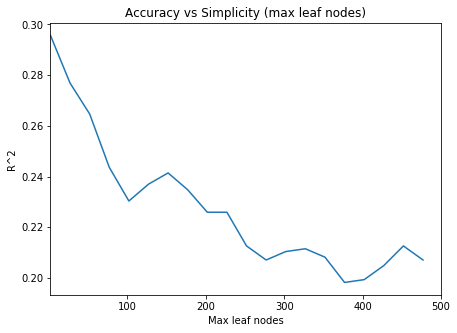

In [92]:
import matplotlib.pylab as plt
plt.figure(figsize=(7,5))
plt.plot(range(2,500,25),OS)
plt.xlabel("Max leaf nodes")
plt.ylabel("R^2")
plt.title("Accuracy vs Simplicity (max leaf nodes)")
plt.xlim(2,500)
plt.show()

In [93]:
# OS=[]
# for i in range(2,500,25):
#     dt=DecisionTreeClassifier(max_depth=ds.best_params_['max_depth'],max_leaf_nodes=ds.best_params_['max_leaf_nodes'])
#     dt.fit(X_train,y_train)
#     OS.append(dt.score(X_test,y_test))
# np.mean(OS), np.max(OS)
# model['DT'] = np.mean(OS)
# model

In [94]:
# def featureImportancePlot(dt, labels):
#     '''plots feature importance for random forest
#     rf: the random forest model fit to the data
#     labels: the names of the features
#     '''
    
#     importances = dt.feature_importances_[:10]
#     indices = np.argsort(importances)[::-1]
#     std = np.std([tree.feature_importances_ for tree in dt.estimators_],
#              axis=0)

#     pl.figure()
#     pl.title("Feature importances")
#     pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
#        color="SteelBlue", yerr=std[indices], align="center")
#     pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
#     pl.xlim([-1, indices.shape[0]])
#     pl.show()
# featureImportancePlot(dt, X_foursquare.columns)

# Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [96]:
param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
rf=RandomForestClassifier()
gr=GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
rs=gr.fit(X_train,y_train)
print (rs.best_params_)
print(gr.score(X_test,y_test))
model

/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 10, 'max_leaf_nodes': 8, 'n_estimators': 3}
0.2912513842746401


{'Logit': 0.292358803986711, 'DT': 0.2956810631229236}

In [97]:
print(y_train.shape, X_train.shape)

OS = []
for c in range(5):

    rf=RandomForestClassifier()

    rf = RandomForestClassifier(max_depth=rs.best_params_['max_depth'],max_leaf_nodes=rs.best_params_['max_leaf_nodes'])
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)[:,1]
    OS.append(rf.score(X_test,y_test))
    
print(rf.score(X_test,y_test))
model['RF'] = mean(OS)
model

(2105,) (2105, 711)


/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

0.2912513842746401


{'Logit': 0.292358803986711,
 'DT': 0.2956810631229236,
 'RF': 0.29346622369878184}

In [277]:
# Manual regularisation

[0.2956810631229236, 0.2956810631229236, 0.2558139534883721, 0.29457364341085274, 0.2967884828349945, 0.2602436323366556, 0.28349944629014395, 0.28349944629014395, 0.27906976744186046, 0.2978959025470653, 0.2702104097452935, 0.29900332225913623, 0.27464008859357697, 0.292358803986711, 0.26578073089701, 0.28460686600221485, 0.2823920265780731, 0.26799557032115173]


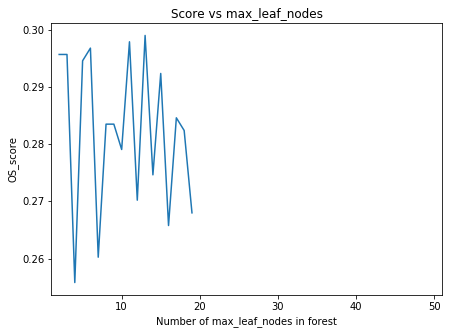

In [98]:
score=[]
for i in range(2,20,1):
    rf = RandomForestClassifier(n_estimators=1, max_leaf_nodes=i)
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)
#     print(X_test.shape)
#     print(pred.shape,y_test.shape)
    score.append(rf.score(X_test,y_test))
print(score)


plt.figure(figsize=(7,5))
plt.plot(range(2,20,1),score)
plt.xlabel("Number of max_leaf_nodes in forest")
plt.ylabel("OS_score")
plt.title("Score vs max_leaf_nodes")
plt.xlim(1,51)
plt.show()

In [99]:
seed = 5
print(y_train.shape, X_train.shape)

rf=RandomForestClassifier()

rf = RandomForestClassifier(max_depth=rs.best_params_['max_depth'],max_leaf_nodes=rs.best_params_['max_leaf_nodes'])
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
rf.score(X_test,y_test)

print(rf.score(X_test,y_test))


(2105,) (2105, 711)
0.2967884828349945


/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.25692137320044295, 0.2912513842746401, 0.2967884828349945, 0.2779623477297896, 0.29346622369878184, 0.29346622369878184, 0.2978959025470653, 0.2912513842746401, 0.2967884828349945, 0.2967884828349945, 0.29346622369878184, 0.301218161683278, 0.29457364341085274, 0.2912513842746401, 0.292358803986711, 0.2967884828349945, 0.2978959025470653, 0.2967884828349945, 0.3001107419712071]


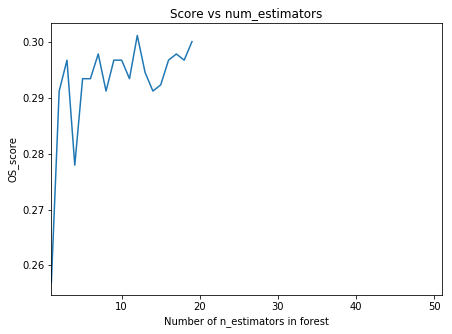

In [100]:

score=[]
for i in range(1,20,1):
    rf = RandomForestClassifier(n_estimators=i, max_leaf_nodes=10)
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)
#     print(X_test.shape)
#     print(pred.shape,y_test.shape)
    score.append(rf.score(X_test,y_test))
print(score)

plt.figure(figsize=(7,5))
plt.plot(range(1,20,1),score)
plt.xlabel("Number of n_estimators in forest")
plt.ylabel("OS_score")
plt.title("Score vs num_estimators")
plt.xlim(1,51)
plt.show()

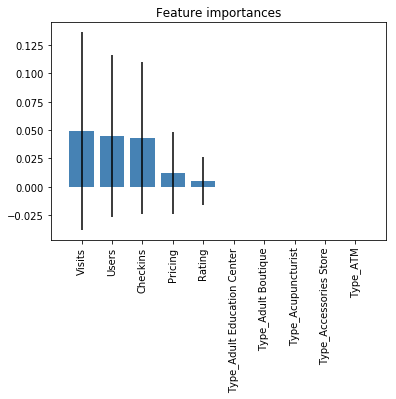

In [101]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:10]
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
featureImportancePlot(rf, X_foursquare.columns)

In [282]:
# SVM

In [103]:
from sklearn.model_selection import GridSearchCV

# When C is very small, we are willing to tolerate more mistakes. If C is very big, this
# means we hardly tolerate any mistakes. So, we cannot choose a very large C if our data is not
# really separable. Let's however choose from a broad range of reasonable options.
# param_grid = {'kernel':['linear'],'C':[np.exp(i) for i in np.linspace(-10,10,10)]}
# OS = []
for c in range(5):
    rr = svm.SVC()
#     gr=GridSearchCV(rr,param_grid=param_grid)
    rr.fit(X_train, y_train)
#     print(rr.best_estimator_)
    correct=1.0*(rr.predict(X_test)==np.asarray(y_test)).sum()/len(y_test)
    
    OS.append(correct)
model['SVM'] = mean(OS)

/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mkm/anaconda3/envs/Pyhton37/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/mkm/anaconda

In [195]:
# plt.gca()
# plt.plot(OS)
# plt.xlabel("log C")
# plt.ylabel("OS accuracy")
# plt.title("Accuracy vs. penalization constant (log C)")
# plt.xlim(-10,10)
# plt.show()
# clf = svm.SVC(kernel='linear')
# clf.fit(X_train, y_train)

# # Report IS and OS results.
# correct_IS=1.0*(clf.predict(X_train)==np.asarray(y_train)).sum()/len(y_train)
# correct_OS=1.0*(clf.predict(X_test)==np.asarray(y_test)).sum()/len(y_test)
# model['SVM'] = clf.score(X_test,y_test)

# print("In sample, we successfully predict {:.4} percent of the data".format((correct_IS)*100))
# print("Out of sample, we successfully predict {:.4} percent of the data".format((correct_OS)*100))

In [104]:
for i in modelslist:
    print(i)
    print(model[i])
model.keys(), model.values()

Logit
0.292358803986711
DT
0.2956810631229236
RF
0.29346622369878184
SVM
0.29346622369878184


(dict_keys(['Logit', 'DT', 'RF', 'SVM']),
 dict_values([0.292358803986711, 0.2956810631229236, 0.29346622369878184, 0.29346622369878184]))

- You can refer to https://github.com/mv1742/updny_2